In [1]:
IMAGE_PATH = "./cropped_receipt/cropped_image.png"

In [2]:
!nvidia-smi

Thu Jul 31 14:32:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              2W /   55W |    2923MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# OCR Space
### Pros:
- Simple implementation

### Cons:
- not accurate enough in OCR detection
- would require paid subscription as it scales due to OCR API

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
OCR_API_KEY=os.getenv("OCR_API_KEY")
OCR_SPACE_SAVE_JSON_PATH = "./outputs/OCR_Space_scanned_text.json"
OCR_SPACE_SAVE_IMG_PATH = "./outputs/OCR_Space_scanned_receipt.png"

In [4]:
import requests
import json

payload = {
    'isOverlayRequired': True,
    'apikey': OCR_API_KEY,
    'language': "eng",
    "isTable": True,
    "scale": True,
}

with open(IMAGE_PATH, 'rb') as f:
    result = requests.post('https://api.ocr.space/parse/image', files={IMAGE_PATH: f}, data=payload).content.decode()

json_result = json.loads(result)

with open(OCR_SPACE_SAVE_JSON_PATH, 'w') as file:
    json.dump(json_result, file, indent=4)


/home/d4rkc10ud/Documents/Projects/ReceiptScanner/receipt_scan_ml/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[49.0, 332.0, 113.0, 347.0]
[58.0, 355.0, 120.0, 373.0]
[58.0, 375.0, 72.0, 386.0]
[82.0, 374.0, 112.0, 386.0]
[121.0, 374.0, 144.0, 386.0]
[58.0, 388.0, 112.0, 401.0]
[121.0, 388.0, 136.0, 401.0]
[57.0, 403.0, 111.0, 415.0]
[121.0, 403.0, 144.0, 415.0]
[57.0, 417.0, 80.0, 430.0]
[89.0, 417.0, 143.0, 429.0]
[57.0, 431.0, 143.0, 444.0]
[57.0, 446.0, 88.0, 457.0]
[97.0, 446.0, 142.0, 457.0]
[56.0, 459.0, 111.0, 471.0]
[64.0, 76.0, 86.0, 87.0]
[94.0, 77.0, 124.0, 88.0]
[133.0, 78.0, 147.0, 88.0]
[155.0, 75.0, 207.0, 88.0]
[216.0, 75.0, 238.0, 85.0]
[247.0, 76.0, 276.0, 85.0]
[285.0, 70.0, 330.0, 82.0]
[64.0, 89.0, 78.0, 100.0]
[87.0, 91.0, 109.0, 101.0]
[117.0, 90.0, 154.0, 101.0]
[125.0, 116.0, 167.0, 128.0]
[171.0, 115.0, 207.0, 128.0]
[92.0, 192.0, 276.0, 227.0]
[95.0, 232.0, 129.0, 244.0]
[135.0, 236.0, 189.0, 248.0]
[195.0, 233.0, 224.0, 245.0]
[229.0, 233.0, 280.0, 245.0]
[138.0, 264.0, 142.0, 276.0]
[154.0, 264.0, 176.0, 276.0]
[186.0, 265.0, 192.0, 276.0]
[200.0, 264.0, 223.0, 276

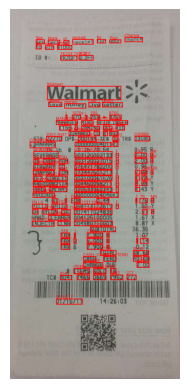

In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, AutoTokenizer

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

path_to_model = "ai-forever/T5-large-spell"
model = T5ForConditionalGeneration.from_pretrained(path_to_model)
tokenizer = AutoTokenizer.from_pretrained(path_to_model)
prefix = "grammar: "

if "ParsedResults" in json_result:
    for parsed_text in json_result["ParsedResults"]:
        if "TextOverlay" in parsed_text:
            for line in parsed_text["TextOverlay"]["Lines"]:
                for word in line["Words"]:
                    box = [word["Left"], word["Top"], word["Left"] + word["Width"], word["Top"] + word["Height"]]
                    print(box)
                    text_position = (word["Left"], word["Top"] - 10)
                    
                    prompt = prefix + word["WordText"]
                    encodings = tokenizer(prompt, return_tensors="pt")
                    generated_tokens = model.generate(**encodings)
                    word = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
                    
                    draw.rectangle(box, outline="red", width=2)
                    draw.text(text_position, word, fill="red")

image.save(OCR_SPACE_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()


# EasyOCR

In [11]:
EASYOCR_SAVE_JSON_PATH = "./outputs/EasyOCR_scanned_text.json"
EASYOCR_SAVE_IMG_PATH = "./outputs/EasyOCR_scanned_receipt.png"

In [12]:
import easyocr

reader = easyocr.Reader(["en"])
results = reader.readtext(IMAGE_PATH)

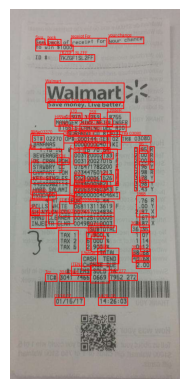

In [13]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

for result in results:
    # print(result)
    box = [result[0][0][0], result[0][0][1], result[0][2][0], result[0][2][1]]
    # print(box)
    text_position = (result[0][0][0], result[0][0][1] - 10)
    word = result[1]
    
    draw.rectangle(box, outline="red", width=2)
    draw.text(text_position, word, fill="red")

image.save(EASYOCR_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()
  

# PaddleOCR

In [ ]:
pip install paddlepaddle-gpu -i https://www.paddlepaddle.org.cn/packages/stable/cu123/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu123/


In [ ]:
PADDLEOCR_SAVE_JSON_PATH = "./outputs/PaddleOCR_scanned_text.json"
PADDLEOCR_SAVE_IMG_PATH = "./outputs/PaddleOCR_scanned_receipt.png"

In [16]:
from paddleocr import PaddleOCR
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

ocr = PaddleOCR(use_angle_cls=True, lang='en')
results = ocr.ocr(IMAGE_PATH, cls=True)

# print(results)

for result in results[0]:
    box = [result[0][0][0], result[0][0][1], result[0][2][0], result[0][2][1]]
    text_position = (result[0][0][0], result[0][0][1] - 10)
    word = result[1][0]
    # print(result[1][0])
    
    draw.rectangle(box, outline="red", width=2)
    draw.text(text_position, word, fill="red")

image.save(PADDLEOCR_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'paddleocr'

# QR Code Scan

In [8]:
import cv2
from pyzbar.pyzbar import decode

gray = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
# increase contrast & sharpness
proc = cv2.adaptiveThreshold(gray, 255,
                             cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY, 15, 4)

for sym in decode(proc):
    print(sym.data.decode())